In [725]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from lib.dataset import Dataset

In [728]:

class dbscan:
    def __init__(self,data,eps=5,minPts=5):
        self.data = data
        self.eps = eps
        self.minPts = minPts
    def getDistance(self,elem1,elem2):
        somme=0
        for j in range(len(elem1)-1):
            somme += abs(elem1[j]-elem2[j])
        return somme
    
    def getNeighbors(self,pointIndex):
        neighbors = []
        for i in range(len(self.data)):
            distance = self.getDistance(self.data[pointIndex],self.data[i])
            if distance <= self.eps:
                neighbors.append(i)
        return neighbors
    
    def getCorePoints(self):
        corePoints = []
        for i in range(len(self.data)):
            neighbors = self.getNeighbors(i)
            if len(neighbors) >= self.minPts:
                corePoints.append(i)
        return corePoints
    
    def clusterCorePoints(self,corePoints):
        clusters = {}
        clusterIndex = 0
        clusters[clusterIndex] = []
        queue = []
        visited = []
        while len(corePoints) >0:

            if len(queue) ==0:
                pointIndex = np.random.choice(corePoints)
            else:
                pointIndex = np.random.choice(queue)
                queue.remove(pointIndex)

            visited.append(pointIndex)
            pointNeighbors = self.getNeighbors(pointIndex)
            for newNeighbor in pointNeighbors:
                if newNeighbor not in queue and newNeighbor not in visited and newNeighbor in corePoints:
                    queue.append(newNeighbor)

            corePoints.remove(pointIndex)
            clustered = False
            # check if point has neighbors in an existing cluster
            for clusterNumber in clusters.keys():
                for neighbor in pointNeighbors:
                    if neighbor in clusters[clusterNumber]:
                        clusters[clusterNumber].append(pointIndex)
                        clustered = True
                        break
                if clustered:
                    break
            # create a cluster for this point
            if not clustered and len(pointNeighbors) > self.minPts:
                clusters[clusterIndex] = [pointIndex]
                clusterIndex += 1

        return clusters

    def fixData(self,clusterCore):
        clusters = {}
        for index in clusterCore.keys():
            for item in clusterCore[index]:
                if index in clusters.keys():
                    clusters[index].append(self.data[item])
                else:
                    clusters[index] = [self.data[item]]
        return clusters
    
    def fillClusters(self,clusterCore,outerPoints):
        for item in outerPoints:
            clustered = False
            for index in clusterCore.keys():
                for core in clusterCore[index]:
                    distance = self.getDistance(self.data[item],self.data[core])
                    if distance <= self.eps:
                        clusterCore[index].append(item)
                        clustered = True
                        outerPoints.remove(item)
                        break
                if clustered:
                    break
        return clusterCore
    
    def run(self):
        #cherche les points centraux
        corePoints = self.getCorePoints()
        print(len(corePoints))
        outerPoints = [i for i in range(len(self.data)) if i not in corePoints]
        #clusterise les points centraux
        clusterCore = self.clusterCorePoints(corePoints)
        #ajoute les outlayer dans les clusters
        filledCore = self.fillClusters(clusterCore,outerPoints)
        #transforme les index en data
        clusters = self.fixData(filledCore)
        return clusters
        

In [729]:
def percent(data):
    clst = {}
    for i,cluster in data.items():
        clst["cluster"+str(i)] = {}
        for item in cluster:
            if item[-1] in clst["cluster"+str(i)].keys():
                clst["cluster"+str(i)][item[-1]] += 1
            else:
                clst["cluster"+str(i)][item[-1]] = 1
    clst = pd.DataFrame(clst)
    clst.replace(np.nan,0,inplace=True)
    print(clst)
    percent = []
    for col in clst.columns:
        percent.append(max(clst[col])/sum(clst[col]))
    print(percent)
    for i,cluster in data.items():
        percent[i] = percent[i]**2 *len(cluster)
    return sum(percent)

In [758]:
Data = pd.read_csv("Data/Dataset1.csv")
ds = Dataset(Data)
ds.preprocessData(null="drop",outliers="Drop",normalisation=None)
Data = ds.data

Index(['N', 'P', 'K', 'pH', 'EC', 'OC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B', 'OM',
       'Fertility'],
      dtype='object')


In [759]:
#scan = dbscan(np.array(Data),eps=28,minPts=4)
#scan = dbscan(np.array(Data),eps=35,minPts=15)
scan = dbscan(np.array(Data),eps=30,minPts=1)
clst = scan.run()
percent(clst)

881
     cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  \
0.0      46.0       161      17.0       3.0       0.0       0.0      23.0   
1.0      31.0       181      11.0       2.0       7.0       2.0       0.0   
2.0       0.0        17       0.0       0.0       0.0       0.0       0.0   

     cluster7  cluster8  cluster9  ...  cluster57  cluster58  cluster59  \
0.0       2.0       2.0       0.0  ...        2.0        3.0        2.0   
1.0       0.0       0.0       8.0  ...        0.0        0.0        0.0   
2.0       0.0       0.0       0.0  ...        0.0        0.0        0.0   

     cluster60  cluster61  cluster62  cluster63  cluster64  cluster65  \
0.0        0.0        2.0        0.0        1.0        0.0        1.0   
1.0        2.0        0.0        2.0        1.0        3.0        1.0   
2.0        0.0        0.0        0.0        0.0        0.0        0.0   

     cluster66  
0.0        2.0  
1.0        0.0  
2.0        0.0  

[3 rows x 67 columns]
[0

348.38710005200556

In [ ]:
from tqdm import tqdm

# Définir la taille de la matrice
rows = 70
cols = 30

# Créer une matrice de couples (i, j)
matrix = [(i, j) for i in range(rows) for j in range(cols)]
result = {}

for i,j in tqdm(matrix):
    scan = dbscan(np.array(Data),eps=i,minPts=j)
    clst = scan.run()
    somme = 0
    for w,items in clst.items():
        somme += len(items)
    try:
        result[(i,j)] = (percent(clst),somme)
    except:
        result[(i,j)] = 0


  0%|          | 0/2100 [00:00<?, ?it/s]

     cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  \
1.0       1.0       0.0       1.0       1.0       0.0       1.0       1.0   
0.0       0.0       1.0       0.0       0.0       1.0       0.0       0.0   
2.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     cluster7  cluster8  cluster9  ...  cluster868  cluster869  cluster870  \
1.0       0.0       0.0       1.0  ...         0.0         1.0         1.0   
0.0       1.0       2.0       0.0  ...         1.0         0.0         0.0   
2.0       0.0       0.0       0.0  ...         0.0         0.0         0.0   

     cluster871  cluster872  cluster873  cluster874  cluster875  cluster876  \
1.0         0.0         1.0         0.0         0.0         1.0         0.0   
0.0         1.0         0.0         1.0         0.0         0.0         1.0   
2.0         0.0         0.0         0.0         1.0         0.0         0.0   

     cluster877  
1.0         0.0  
0.0         1.0  
2.0    

  0%|          | 1/2100 [00:10<6:06:07, 10.47s/it]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

  0%|          | 1/2100 [00:16<9:36:46, 16.49s/it]


KeyboardInterrupt: 

In [3]:
import pickle

result = pickle.load(open("result2.pkl","rb"))

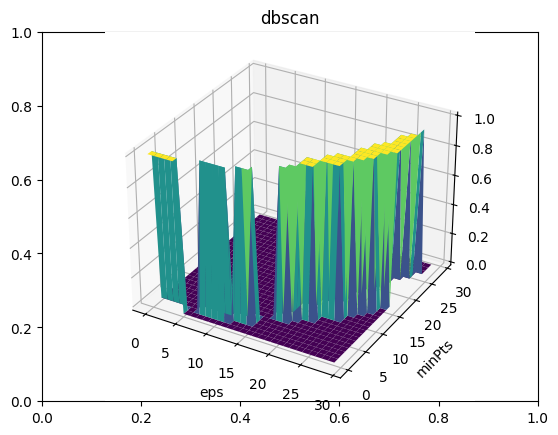

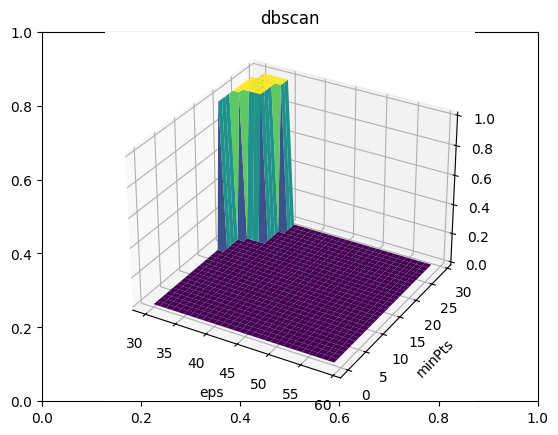

In [43]:
import numpy as np
rows = 30
cols = 30
X = np.array([i for i in range(30)])
Y = np.array([i for i in range(30)])

# Create a meshgrid
X, Y = np.meshgrid(X, Y)

# Initialize Z with zeros
Z = np.zeros_like(X)

# Assign values from the result dictionary
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        try:
            Z[i, j] = result[(X[i, j], Y[i, j])][0] / result[(X[i, j], Y[i, j])][1]
        except:
            Z[i, j] = 0

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')

ax.set_title('dbscan')
ax.set_xlabel('eps')
ax.set_ylabel('minPts')
ax.plot_surface(X, Y, Z,cmap='viridis')
plt.show()

rows = 60
cols = 30
X = np.array([i for i in range(30, 60)])
Y = np.array([i for i in range(30)])

# Create a meshgrid
X, Y = np.meshgrid(X, Y)

# Initialize Z with zeros
Z = np.zeros_like(X)

# Assign values from the result dictionary
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        try:
            Z[i, j] = result[(X[i, j], Y[i, j])][0] / result[(X[i, j], Y[i, j])][1]
        except:
            Z[i, j] = 0


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('dbscan')
ax.set_xlabel('eps')
ax.set_ylabel('minPts')
ax.plot_surface(X, Y, Z,cmap='viridis')

plt.show()